# Prototype 01
## Experiment 03

## Training on Google Collab 

In [1]:
# Mount your google drive in google colab
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

ModuleNotFoundError: No module named 'google'

In [ ]:
# Go to base directory
%cd /content/drive/MyDrive/University/Master-Thesis/Code

## Training on Local Machine

In [1]:
import os

original_working_directory_path = os.getcwd()
print("The original working directory is {0}".format(os.getcwd()))

def to_original_working_directory():
    os.chdir(original_working_directory_path)
    print(f"Changed to original working directory {original_working_directory_path}")
    

The original working directory is /Users/jankreischer/Library/Mobile Documents/com~apple~CloudDocs/Master-Thesis/Code/prototypes/prototype_01


In [2]:
def to_root_working_directory():
    root_working_directory_path = os.path.join(original_working_directory_path, "../..")
    os.chdir(root_working_directory_path)
    print(f"Changed to root working directory {os.getcwd()}")

In [3]:
to_root_working_directory()

Changed to root working directory /Users/jankreischer/Library/Mobile Documents/com~apple~CloudDocs/Master-Thesis/Code


In [4]:
# Validate that python 3.10 is used
!python --version

Python 3.10.10


In [5]:
def seed_random():
    random.seed(42)
    torch.random.manual_seed(42)
    np.random.seed(42)

## --- Dependencies ---

In [6]:
# Standard Dependencies
import sys
import os
import numpy as np
from time import time

In [7]:
# Global Dependencies
from src.custom_types import Behavior, MTDTechnique
from src.data_provider import DataProvider
#from src.agent import Agent
#from src.simulation_engine import SimulationEngine
from src.evaluation_utils import plot_learning, seed_random, get_pretrained_agent, evaluate_agent_on_afterstates

/Users/jankreischer/opt/anaconda3/envs/FedRL-for-IT-Sec/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
from prototypes.prototype_01.sensor_environment import SensorEnvironment
from prototypes.prototype_01.agent import Agent
from prototypes.prototype_01.client import Client
from prototypes.prototype_01.enums import Execution, Evaluation
from prototypes.prototype_01.server import Server
from prototypes.prototype_01.experiment import Experiment

## --- Hyperparameters ---

In [9]:
# Hyperparams

GAMMA = 0.95 #0.99 # discount factor for future rewards
BATCH_SIZE = 100
N_EPISODES = 10000

NR_ROUNDS = 10
NR_EPISODES_PER_ROUND = 1000

BUFFER_SIZE = 500
MIN_REPLAY_SIZE = 100
# Epsilon determining Exploration Exploitation Trade Off
EPSILON_START = 1.0
EPSILON_DEC = 1e-4 # 0.0001
EPSILON_END = 0.01

TARGET_UPDATE_FREQ = 100
LEARNING_RATE = 1e-4

----------

## Experiment

/Users/jankreischer/Library/Mobile Documents/com~apple~CloudDocs/Master-Thesis/Code
>>> SERVER TRAINING ROUND 1/10 <<<
Evaluating round 1
Agent 1 learning curve


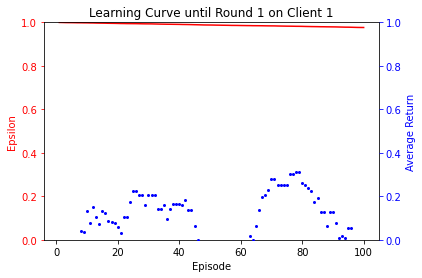

Agent 2 learning curve


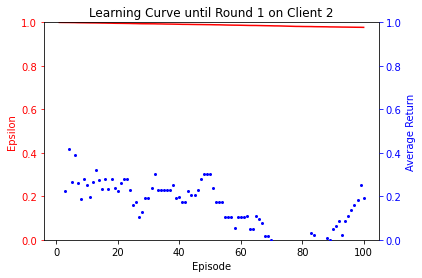

PERFORMANCE EVALUATION
Agent 1 > Performance Evaluation
| Behavior           |   Accuracy | Objective                      |
|:-------------------|-----------:|:-------------------------------|
| ransomware_poc     |       0    | ransomware_file_extension_hide |
| bdvl               |      44.02 | rootkit_sanitizer              |
| beurk              |       0.14 | rootkit_sanitizer              |
| the_tick           |      99.93 | cnc_ip_shuffle                 |
| backdoor_jakoritar |      99.77 | cnc_ip_shuffle                 |
| data_leak_1        |     100    | cnc_ip_shuffle                 |
| data_leak_2        |     100    | cnc_ip_shuffle                 |

Agent 1 > Confusion Matrix
| MTD_true/ MTD_pred             |   cnc_ip_shuffle |   rootkit_sanitizer |   ransomware_directory_trap |   ransomware_file_extension_hide |
|:-------------------------------|-----------------:|--------------------:|----------------------------:|---------------------------------:|
| cnc_ip_shuf

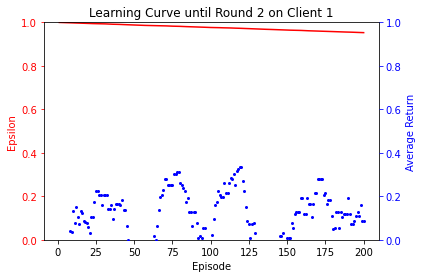

Agent 2 learning curve


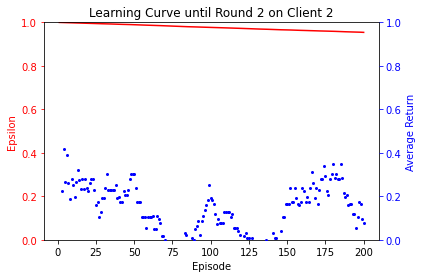

PERFORMANCE EVALUATION
Agent 1 > Performance Evaluation
| Behavior           |   Accuracy | Objective                      |
|:-------------------|-----------:|:-------------------------------|
| ransomware_poc     |        0   | ransomware_file_extension_hide |
| bdvl               |       61.2 | rootkit_sanitizer              |
| beurk              |        0   | rootkit_sanitizer              |
| the_tick           |      100   | cnc_ip_shuffle                 |
| backdoor_jakoritar |      100   | cnc_ip_shuffle                 |
| data_leak_1        |      100   | cnc_ip_shuffle                 |
| data_leak_2        |      100   | cnc_ip_shuffle                 |

Agent 1 > Confusion Matrix
| MTD_true/ MTD_pred             |   cnc_ip_shuffle |   rootkit_sanitizer |   ransomware_directory_trap |   ransomware_file_extension_hide |
|:-------------------------------|-----------------:|--------------------:|----------------------------:|---------------------------------:|
| cnc_ip_shuf

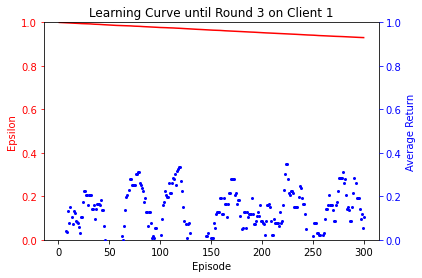

Agent 2 learning curve


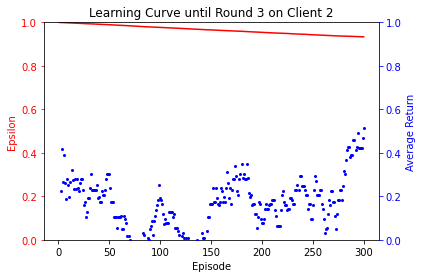

PERFORMANCE EVALUATION
Agent 1 > Performance Evaluation
| Behavior           |   Accuracy | Objective                      |
|:-------------------|-----------:|:-------------------------------|
| ransomware_poc     |       0    | ransomware_file_extension_hide |
| bdvl               |      67.76 | rootkit_sanitizer              |
| beurk              |       0.14 | rootkit_sanitizer              |
| the_tick           |      99.93 | cnc_ip_shuffle                 |
| backdoor_jakoritar |     100    | cnc_ip_shuffle                 |
| data_leak_1        |      99.82 | cnc_ip_shuffle                 |
| data_leak_2        |     100    | cnc_ip_shuffle                 |

Agent 1 > Confusion Matrix
| MTD_true/ MTD_pred             |   cnc_ip_shuffle |   rootkit_sanitizer |   ransomware_directory_trap |   ransomware_file_extension_hide |
|:-------------------------------|-----------------:|--------------------:|----------------------------:|---------------------------------:|
| cnc_ip_shuf

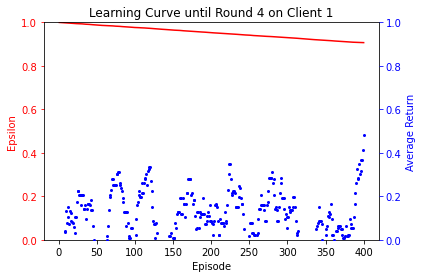

Agent 2 learning curve


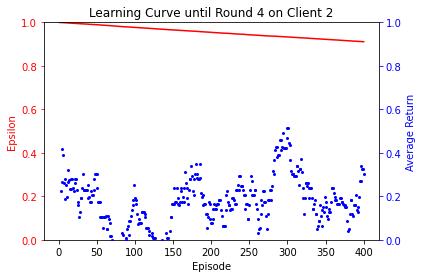

PERFORMANCE EVALUATION
Agent 1 > Performance Evaluation
| Behavior           |   Accuracy | Objective                      |
|:-------------------|-----------:|:-------------------------------|
| ransomware_poc     |      93.46 | ransomware_file_extension_hide |
| bdvl               |      71.74 | rootkit_sanitizer              |
| beurk              |       0.14 | rootkit_sanitizer              |
| the_tick           |      99.93 | cnc_ip_shuffle                 |
| backdoor_jakoritar |     100    | cnc_ip_shuffle                 |
| data_leak_1        |      99.73 | cnc_ip_shuffle                 |
| data_leak_2        |     100    | cnc_ip_shuffle                 |

Agent 1 > Confusion Matrix
| MTD_true/ MTD_pred             |   cnc_ip_shuffle |   rootkit_sanitizer |   ransomware_directory_trap |   ransomware_file_extension_hide |
|:-------------------------------|-----------------:|--------------------:|----------------------------:|---------------------------------:|
| cnc_ip_shuf

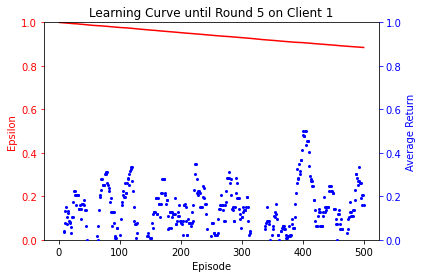

Agent 2 learning curve


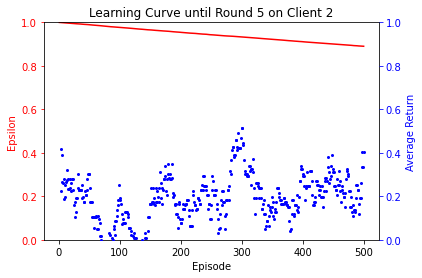

PERFORMANCE EVALUATION
Agent 1 > Performance Evaluation
| Behavior           |   Accuracy | Objective                      |
|:-------------------|-----------:|:-------------------------------|
| ransomware_poc     |      98.55 | ransomware_file_extension_hide |
| bdvl               |      92.56 | rootkit_sanitizer              |
| beurk              |       2.05 | rootkit_sanitizer              |
| the_tick           |      99.22 | cnc_ip_shuffle                 |
| backdoor_jakoritar |      98.59 | cnc_ip_shuffle                 |
| data_leak_1        |      99.56 | cnc_ip_shuffle                 |
| data_leak_2        |     100    | cnc_ip_shuffle                 |

Agent 1 > Confusion Matrix
| MTD_true/ MTD_pred             |   cnc_ip_shuffle |   rootkit_sanitizer |   ransomware_directory_trap |   ransomware_file_extension_hide |
|:-------------------------------|-----------------:|--------------------:|----------------------------:|---------------------------------:|
| cnc_ip_shuf

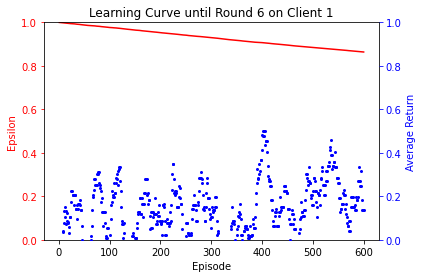

Agent 2 learning curve


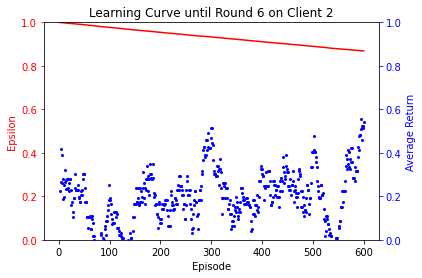

PERFORMANCE EVALUATION
Agent 1 > Performance Evaluation
| Behavior           |   Accuracy | Objective                      |
|:-------------------|-----------:|:-------------------------------|
| ransomware_poc     |      98.77 | ransomware_file_extension_hide |
| bdvl               |      99.38 | rootkit_sanitizer              |
| beurk              |      29.3  | rootkit_sanitizer              |
| the_tick           |      84.65 | cnc_ip_shuffle                 |
| backdoor_jakoritar |      76.29 | cnc_ip_shuffle                 |
| data_leak_1        |      99.38 | cnc_ip_shuffle                 |
| data_leak_2        |     100    | cnc_ip_shuffle                 |

Agent 1 > Confusion Matrix
| MTD_true/ MTD_pred             |   cnc_ip_shuffle |   rootkit_sanitizer |   ransomware_directory_trap |   ransomware_file_extension_hide |
|:-------------------------------|-----------------:|--------------------:|----------------------------:|---------------------------------:|
| cnc_ip_shuf

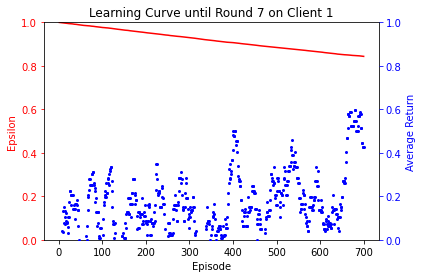

Agent 2 learning curve


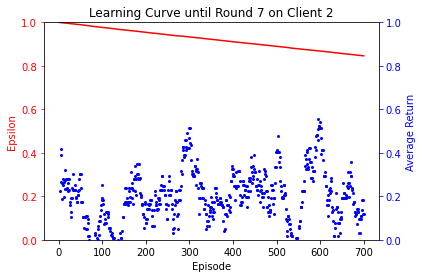

PERFORMANCE EVALUATION
Agent 1 > Performance Evaluation
| Behavior           |   Accuracy | Objective                      |
|:-------------------|-----------:|:-------------------------------|
| ransomware_poc     |      98.71 | ransomware_file_extension_hide |
| bdvl               |      98.85 | rootkit_sanitizer              |
| beurk              |      25.33 | rootkit_sanitizer              |
| the_tick           |      93.01 | cnc_ip_shuffle                 |
| backdoor_jakoritar |      81.1  | cnc_ip_shuffle                 |
| data_leak_1        |      99.47 | cnc_ip_shuffle                 |
| data_leak_2        |     100    | cnc_ip_shuffle                 |

Agent 1 > Confusion Matrix
| MTD_true/ MTD_pred             |   cnc_ip_shuffle |   rootkit_sanitizer |   ransomware_directory_trap |   ransomware_file_extension_hide |
|:-------------------------------|-----------------:|--------------------:|----------------------------:|---------------------------------:|
| cnc_ip_shuf

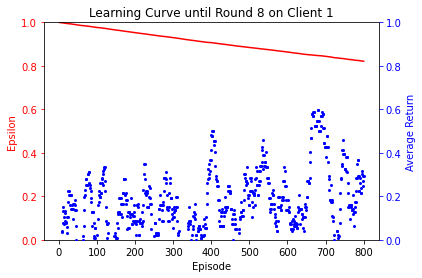

Agent 2 learning curve


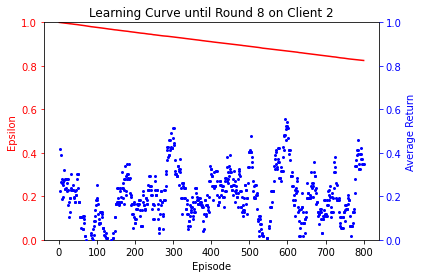

PERFORMANCE EVALUATION
Agent 1 > Performance Evaluation
| Behavior           |   Accuracy | Objective                      |
|:-------------------|-----------:|:-------------------------------|
| ransomware_poc     |      98.77 | ransomware_file_extension_hide |
| bdvl               |      97.34 | rootkit_sanitizer              |
| beurk              |      16.84 | rootkit_sanitizer              |
| the_tick           |      96.34 | cnc_ip_shuffle                 |
| backdoor_jakoritar |      88.38 | cnc_ip_shuffle                 |
| data_leak_1        |      99.47 | cnc_ip_shuffle                 |
| data_leak_2        |     100    | cnc_ip_shuffle                 |

Agent 1 > Confusion Matrix
| MTD_true/ MTD_pred             |   cnc_ip_shuffle |   rootkit_sanitizer |   ransomware_directory_trap |   ransomware_file_extension_hide |
|:-------------------------------|-----------------:|--------------------:|----------------------------:|---------------------------------:|
| cnc_ip_shuf

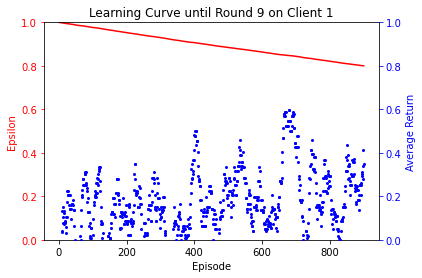

Agent 2 learning curve


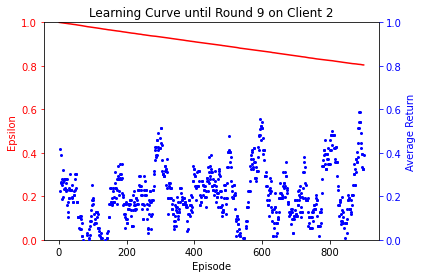

PERFORMANCE EVALUATION
Agent 1 > Performance Evaluation
| Behavior           |   Accuracy | Objective                      |
|:-------------------|-----------:|:-------------------------------|
| ransomware_poc     |      98.77 | ransomware_file_extension_hide |
| bdvl               |      99.11 | rootkit_sanitizer              |
| beurk              |      21.22 | rootkit_sanitizer              |
| the_tick           |      95.62 | cnc_ip_shuffle                 |
| backdoor_jakoritar |      84.39 | cnc_ip_shuffle                 |
| data_leak_1        |      99.47 | cnc_ip_shuffle                 |
| data_leak_2        |     100    | cnc_ip_shuffle                 |

Agent 1 > Confusion Matrix
| MTD_true/ MTD_pred             |   cnc_ip_shuffle |   rootkit_sanitizer |   ransomware_directory_trap |   ransomware_file_extension_hide |
|:-------------------------------|-----------------:|--------------------:|----------------------------:|---------------------------------:|
| cnc_ip_shuf

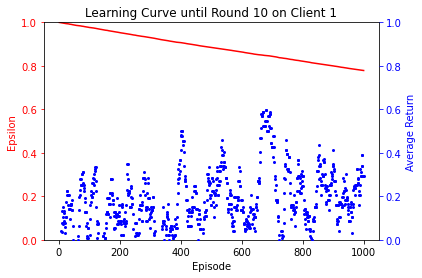

Agent 2 learning curve


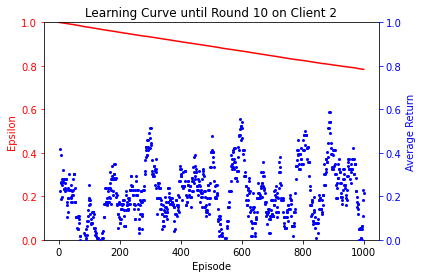

PERFORMANCE EVALUATION
Agent 1 > Performance Evaluation
| Behavior           |   Accuracy | Objective                      |
|:-------------------|-----------:|:-------------------------------|
| ransomware_poc     |      98.77 | ransomware_file_extension_hide |
| bdvl               |      99.29 | rootkit_sanitizer              |
| beurk              |      44.15 | rootkit_sanitizer              |
| the_tick           |      92.88 | cnc_ip_shuffle                 |
| backdoor_jakoritar |      67.25 | cnc_ip_shuffle                 |
| data_leak_1        |      99.29 | cnc_ip_shuffle                 |
| data_leak_2        |     100    | cnc_ip_shuffle                 |

Agent 1 > Confusion Matrix
| MTD_true/ MTD_pred             |   cnc_ip_shuffle |   rootkit_sanitizer |   ransomware_directory_trap |   ransomware_file_extension_hide |
|:-------------------------------|-----------------:|--------------------:|----------------------------:|---------------------------------:|
| cnc_ip_shuf

In [10]:
if __name__ == '__main__':
    experiments = Experiment(original_working_directory_path)
    experiment_id = 3
    experiment_version = 0
    experiment_path = experiments.get_experiment_path(experiment_id, experiment_version)

    EPSILON_START = 1.0
    EPSILON_DEC = 1e-4
    EPSILON_END = 0.01
    NR_ROUNDS = 10
    NR_EPISODES_PER_ROUND = 100
    N_SAMPLES = 1000

    training_data, test_data, _ = DataProvider.get_scaled_train_test_split(scaling_minmax=True, scale_normal_only=True)

    sampling_probabilities_1 = {
        #Behavior.NORMAL: 0,
        Behavior.ROOTKIT_BDVL: 1/7,
        Behavior.ROOTKIT_BEURK: 1/7,
        Behavior.CNC_BACKDOOR_JAKORITAR: 1/7,
        Behavior.CNC_THETICK: 1/7, 
        Behavior.CNC_OPT1: 1/7,
        Behavior.CNC_OPT2: 1/7,
        Behavior.RANSOMWARE_POC: 1/7
    }

    sampling_probabilities_2 = {
        #Behavior.NORMAL: 0,
        Behavior.ROOTKIT_BDVL: 1/7,
        Behavior.ROOTKIT_BEURK: 1/7,
        Behavior.CNC_BACKDOOR_JAKORITAR: 1/7,
        Behavior.CNC_THETICK: 1/7, 
        Behavior.CNC_OPT1: 1/7,
        Behavior.CNC_OPT2: 1/7,
        Behavior.RANSOMWARE_POC: 1/7
    }

    n_samples_1 = np.array(list(sampling_probabilities_1.values()))*N_SAMPLES
    n_samples_2 = np.array(list(sampling_probabilities_2.values()))*N_SAMPLES

    sample_matrix = np.vstack([n_samples_1, n_samples_2])

    #print(f"MID: {multiclass_imbalance_degree(sample_matrix)}")
    #print(f"WCS: {weighted_cosine_similarity(sample_matrix)}")

    environment_01 = SensorEnvironment(training_data, sampling_probabilities_1)
    environment_02 = SensorEnvironment(training_data, sampling_probabilities_2)

    global_agent = Agent(0, input_dims=environment_02.observation_space_size, n_actions=len(environment_02.actions), buffer_size=BUFFER_SIZE,
                    batch_size=BATCH_SIZE, lr=LEARNING_RATE, gamma=GAMMA, epsilon=EPSILON_START, eps_end=EPSILON_END, eps_dec=EPSILON_DEC)

    agent_01 = Agent(1, input_dims=environment_01.observation_space_size, n_actions=len(environment_01.actions), buffer_size=BUFFER_SIZE,
                  batch_size=BATCH_SIZE, lr=LEARNING_RATE, gamma=GAMMA, epsilon=EPSILON_START, eps_end=EPSILON_END, eps_dec=EPSILON_DEC)

    agent_02 = Agent(2, input_dims=environment_02.observation_space_size, n_actions=len(environment_02.actions), buffer_size=BUFFER_SIZE,
                    batch_size=BATCH_SIZE, lr=LEARNING_RATE, gamma=GAMMA, epsilon=EPSILON_START, eps_end=EPSILON_END, eps_dec=EPSILON_DEC)

    server = Server(global_agent, test_data, experiment_id, experiment_path, nr_rounds=NR_ROUNDS, nr_episodes_per_round=NR_EPISODES_PER_ROUND)

    client_01 = Client(1, agent_01, environment_01, experiment_path, MIN_REPLAY_SIZE)
    client_02 = Client(2, agent_02, environment_02, experiment_path, MIN_REPLAY_SIZE)

    server.add_client(client_01)
    server.add_client(client_02)

    evaluations = [Evaluation.TRAINING_TIME, Evaluation.PERFORMANCE_EVALUATION, Evaluation.LEARNING_CURVE, Evaluation.CONFUSION_MATRIX]
    server.run_federation(evaluations=evaluations, evaluation_frequency=1)